# COVID Global Clustering Scratchpad 

Do the same using Global data from John Hopkins University

https://github.com/CSSEGISandData/COVID-19   

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


## Clustering thoughts
- Take case + death counts
- Trending pattern (?  what is a good single value metric.. rolling 3 day or some momentum value?)
- Adding population data
- Population density ?
- Median age and age distributions

Attempt to cluster the countries ?


In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False)
dfc_g = dfc_g.transpose()  
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail())
display('chg in cases',dfc_g.tail().diff(axis=0))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False)
dfd_g = dfd_g.transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index) 
display('deaths',dfd_g.tail())
display('chg in deaths',dfd_g.tail().diff(axis=0))

#display('details of', dfd_g['Sudan'].tail(15), dfc_g['Sudan'].tail(15))


'cases'

Country/Region,US,Spain,Italy,France,Germany,China,Iran,United Kingdom,Turkey,Belgium,...,Mauritania,Botswana,Bhutan,Western Sahara,Gambia,Sao Tome and Principe,Burundi,Papua New Guinea,South Sudan,Timor-Leste
2020-04-04,308853,126168,124632,90848,96092,82543,55743,42477,23934,18431,...,6,4,5,0,4,0,3,1,0,1
2020-04-05,337072,131646,128948,93773,100123,82602,58226,48436,27069,19691,...,6,6,5,4,4,0,3,1,1,1
2020-04-06,366667,136675,132547,98963,103374,82665,60500,52279,30217,20814,...,6,6,5,4,4,4,3,2,1,1
2020-04-07,396223,141942,135586,110065,107663,82718,62589,55949,34109,22194,...,6,6,5,4,4,4,3,2,2,1
2020-04-08,429052,148220,139422,113959,113296,82809,64586,61474,38226,23403,...,6,6,5,4,4,4,3,2,2,1


'chg in cases'

Country/Region,US,Spain,Italy,France,Germany,China,Iran,United Kingdom,Turkey,Belgium,...,Mauritania,Botswana,Bhutan,Western Sahara,Gambia,Sao Tome and Principe,Burundi,Papua New Guinea,South Sudan,Timor-Leste
2020-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-05,28219.0,5478.0,4316.0,2925.0,4031.0,59.0,2483.0,5959.0,3135.0,1260.0,...,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-04-06,29595.0,5029.0,3599.0,5190.0,3251.0,63.0,2274.0,3843.0,3148.0,1123.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0
2020-04-07,29556.0,5267.0,3039.0,11102.0,4289.0,53.0,2089.0,3670.0,3892.0,1380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-04-08,32829.0,6278.0,3836.0,3894.0,5633.0,91.0,1997.0,5525.0,4117.0,1209.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'deaths'

Country/Region,Italy,Spain,US,France,United Kingdom,Iran,China,Germany,Netherlands,Belgium,...,Equatorial Guinea,Guinea,Dominica,South Sudan,Djibouti,Guinea-Bissau,Papua New Guinea,Holy See,Chad,Eswatini
2020-04-04,15362,11947,8407,7574,4320,3452,3330,1444,1656,1283,...,0,0,0,0,0,0,0,0,0,0
2020-04-05,15887,12641,9619,8093,4943,3603,3333,1584,1771,1447,...,0,0,0,0,0,0,0,0,0,0
2020-04-06,16523,13341,10783,8926,5385,3739,3335,1810,1874,1632,...,0,0,0,0,0,0,0,0,0,0
2020-04-07,17127,14045,12722,10343,6171,3872,3335,2016,2108,2035,...,0,0,0,0,0,0,0,0,0,0
2020-04-08,17669,14792,14695,10887,7111,3993,3337,2349,2255,2240,...,0,0,0,0,0,0,0,0,0,0


'chg in deaths'

Country/Region,Italy,Spain,US,France,United Kingdom,Iran,China,Germany,Netherlands,Belgium,...,Equatorial Guinea,Guinea,Dominica,South Sudan,Djibouti,Guinea-Bissau,Papua New Guinea,Holy See,Chad,Eswatini
2020-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-05,525.0,694.0,1212.0,519.0,623.0,151.0,3.0,140.0,115.0,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-06,636.0,700.0,1164.0,833.0,442.0,136.0,2.0,226.0,103.0,185.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-07,604.0,704.0,1939.0,1417.0,786.0,133.0,0.0,206.0,234.0,403.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-08,542.0,747.0,1973.0,544.0,940.0,121.0,2.0,333.0,147.0,205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Global Population Comparisons

In [165]:
# GLobal Population 
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})

display(df_gpop_2016.sort_values(by=['Value'], ascending=False).head(), dfc_g.tail(1).transpose().count())  #262 countries / n countries
df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

display(df_gmerged.rename(columns={'US':'United States'}).sort_values(by=['Population'], ascending=False).head())

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })
       
display(df_gmerged.sort_values(by=['Population'], ascending=False).head(), df_gmerged.tail(1).transpose().count())



,Country/Region,Country Code,Year,Value
2621,World,WLD,2016,7.442136e+09
968,IDA & IBRD total,IBT,2016,6.271593e+09
1481,Low & middle income,LMY,2016,6.252106e+09
1823,Middle income,MIC,2016,5.592833e+09
911,IBRD only,IBD,2016,4.697247e+09


2020-04-08    184
dtype: int64

,Country/Region,Cases,Country Code,Year,Population
5,China,82809,CHN,2016,1.378665e+09
20,India,5916,IND,2016,1.324171e+09
0,United States,429052,USA,2016,3.231275e+08
32,Indonesia,2956,IDN,2016,2.611155e+08
12,Brazil,16170,BRA,2016,2.076529e+08


,Country/Region,Deaths,Cases,Country Code,Year,Population
5,China,3337,82809,CHN,2016,1.378665e+09
23,India,178,5916,IND,2016,1.324171e+09
2,United States,14695,429052,USA,2016,3.231275e+08
17,Indonesia,240,2956,IDN,2016,2.611155e+08
10,Brazil,819,16170,BRA,2016,2.076529e+08


156    6
dtype: int64

## Add Population Density from worldbank

In [171]:
# population density source
# http://api.worldbank.org/v2/en/indicator/EN.POP.DNST?downloadformat=csv   
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def get_zip(url):
    urllib.request.urlretrieve(url, "GDP.zip")
    compressed_file = zipfile.ZipFile('GDP.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)  # pattern match how?
            return pd.read_csv(csv_file, header=2)
    return None
    
popdensity = get_zip('http://api.worldbank.org/v2/en/indicator/EN.POP.DNST?downloadformat=csv')
popdensity = pd.concat([popdensity.iloc[:,0:2], popdensity['2018']], axis=1).rename(columns={'2018':'popdensity'})

df_gmerged2 = pd.merge(left=df_gmerged, right=popdensity, on='Country Code', how='left')
df_gmerged2['% of pop'] = (df_gmerged2['Cases'] / df_gmerged2['Population']).mul(100).round(2)

display(df_gmerged.shape, popdensity.shape, df_gmerged2.shape)
display(popdensity.head(), df_gmerged2.head().sort_values(by='Population', ascending=False))

(157, 6)

(264, 3)

(157, 9)

,Country Name,Country Code,popdensity
0,Aruba,ABW,588.027778
1,Afghanistan,AFG,56.937760
2,Angola,AGO,24.713052
3,Albania,ALB,104.612263
4,Andorra,AND,163.842553


,Country/Region,Deaths,Cases,Country Code,Year,Population,Country Name,popdensity,% of pop
2,United States,14695,429052,USA,2016,323127513.0,United States,35.766089,0.13
3,France,10887,113959,FRA,2016,66896109.0,France,122.338396,0.17
4,United Kingdom,7111,61474,GBR,2016,65637239.0,United Kingdom,274.827392,0.09
0,Italy,17669,139422,ITA,2016,60600590.0,Italy,205.450748,0.23
1,Spain,14792,148220,ESP,2016,46443959.0,Spain,93.529058,0.32


## Add demographics

In [198]:
#  -- all available https://data.worldbank.org/indicator
# unemployment data http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# hospital beds http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
# air flights http://api.worldbank.org/v2/en/indicator/IS.AIR.DPRT?downloadformat=csv
# rail lines http://api.worldbank.org/v2/en/indicator/IS.RRS.TOTL.KM?downloadformat=csv
# employment F http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.FE.ZS?downloadformat=csv
# employment M http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.MA.ZS?downloadformat=csv
# unemployment http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# urban pop http://api.worldbank.org/v2/en/indicator/SP.URB.TOTL.IN.ZS?downloadformat=csv

# need to get the last column w/ data tsince its very sparse

df_uemp = get_zip('http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv')
df_uemp = df_uemp.fillna(method='ffill')[['Country Code', '2019']].rename(columns={'2019':'Unemp%'})
display(df_uemp.shape, df_gmerged2.shape)

df_gmerged3 = pd.merge(left=df_gmerged2, right=df_uemp, on ='Country Code') 
df_gmerged3['Population/M'] = df_gmerged3['Population'].div(10**6).round(2)
df_gmerged3['Unemp%'] = df_gmerged3['Unemp%'].round(2)
df_gmerged3['popdensity'] = df_gmerged3['popdensity'].round(2)
df_gmerged3 = df_gmerged3.sort_values(by='Unemp%', ascending=False)[['Country/Region','Deaths','Cases','Population/M','popdensity','% of pop','Unemp%']]
df_gmerged3 = df_gmerged3[df_gmerged3['Cases'] > 1000]

display(df_gmerged3.shape, df_gmerged3)


(264, 2)

(157, 9)

(58, 7)

,Country/Region,Deaths,Cases,Population/M,popdensity,% of pop,Unemp%
62,South Africa,18,1845,55.91,47.63,0.00,28.18
31,Greece,83,1884,10.75,83.22,0.02,17.24
1,Spain,14792,148220,46.44,93.53,0.32,13.96
11,Turkey,812,38226,79.51,106.96,0.05,13.49
33,Iraq,69,1202,37.20,88.53,0.00,12.82
35,Serbia,65,2666,7.06,79.83,0.04,12.69
10,Brazil,819,16170,207.65,25.06,0.01,12.08
21,Algeria,205,1572,40.61,17.73,0.00,11.70
0,Italy,17669,139422,60.60,205.45,0.23,9.89
36,Argentina,63,1715,43.85,16.26,0.00,9.79


# Pop Density vs Case counts

C:\Users\dougc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: `item` has been deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


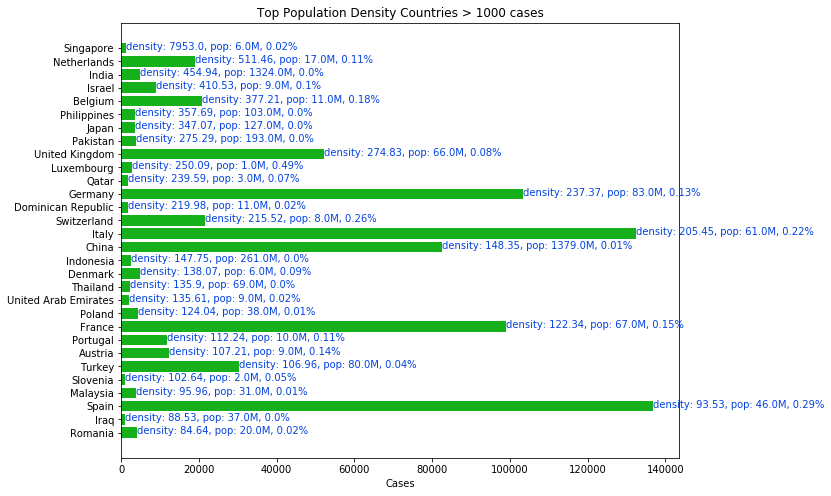

In [123]:
max_ctys = 30
fig,ax1 = plt.subplots(figsize=(10, 8)) 

df_gmerged_h = df_gmerged2[df_gmerged2['Cases'] > 1000].sort_values(by=['popdensity'],ascending=False).head(max_ctys)

ax1.set_xlabel('Cases')  
ax1.set_xscale('linear')
ax1.barh(df_gmerged_h['Country/Region'], df_gmerged_h['Cases'], color='xkcd:green')
for n,i in enumerate(ax1.patches):
    ax1.text(i.get_width()+.02, i.get_y()+.5,'density: '+str(df_gmerged_h['popdensity'].iloc[n:n+1].round(2).item()) + ', pop: '+str(df_gmerged_h['Population'].iloc[n:n+1].div(1000000).round(0).item()) +'M, '+str(df_gmerged_h['% of pop'].iloc[n:n+1].round(2).item())  +'%', color='xkcd:blue')

# ax2 = ax1.twiny()
# ax2.set_xscale('linear')
# ax2.set(xlim=[0, 10])   # get max min +/- buffer
# ax2.set_xlabel('Population density', color='xkcd:red')  
# ax2.spines['top'].set_color('red')
# ax2.tick_params(axis='x', colors='red')
# ax2.barh(df_gmerged_h['Country/Region'], df_gmerged_h['popdensity'], color='xkcd:red')
# for n,i in enumerate(ax2.patches):
#     ax2.text(i.get_width()+.02, i.get_y()+.5,str(df_gmerged_h['popdensity'].iloc[n:n+1].item()), color='xkcd:red')

plt.title('Top Population Density Countries > 1000 cases')
plt.gca().invert_yaxis()
plt.show()